In [ ]:
# pipenv install pandas scipy plotly scikit-learn optuna shap ipykernel ipywidgets nbformat numpy==2.0 matplotlib shap

In [97]:
import pandas as pd
import numpy as np 
from scipy.stats import chi2_contingency

import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import shap

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import recall_score,classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, precision_score
import optuna

### Carregar Dataset

In [3]:
df_employee = pd.read_csv(r".\datasets\churn.csv", 
                          parse_dates=["data_contratacao", "data_demissao", "data_ultimo_feedback",
                                       "data_ultimo_aumento", "data_ultima_mudanca_cargo"], 
                          date_format="%Y-%m-%d")

In [4]:
df_employee.head(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0
5,EMP1053,49,Outro,Casado(a),Technical Degree,Híbrido,2020-01-08,NaT,NaN,Junior Developer,6507,2022-06-01,2020-07-05,2021-09-02,7.9,True,8,4,7.1,0
6,EMP1152,29,M,Casado(a),PhD,Presencial,2020-01-10,2022-08-22,Involuntária,Product Manager,12575,2020-10-16,2020-08-11,2022-02-27,9.1,True,6,3,1.9,1
7,EMP1317,38,F,Viúvo(a),PhD,Remoto,2020-01-11,NaT,NaN,DevOps Engineer,16643,2023-03-28,2023-05-16,2022-03-28,8.9,False,6,4,8.3,0
8,EMP1398,33,M,Casado(a),Technical Degree,Remoto,2020-01-12,NaT,NaN,DevOps Engineer,16771,2024-01-03,2024-03-13,2024-06-15,7.6,False,8,1,1.2,0
9,EMP0167,23,M,Viúvo(a),PhD,Híbrido,2020-01-13,NaT,NaN,QA Engineer,13258,2022-01-02,2021-09-15,2024-04-04,8.1,True,3,6,7.0,0


In [5]:
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

### Engenharia de Features

In [6]:
# Criar features baseadas na difernça de datas

df_employee['tempo_empresa'] = df_employee.apply(lambda x: 
    (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0
    else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

df_employee['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employee['data_ultimo_feedback']).dt.days
df_employee['dias_desde_ultimo_aumento'] = (pd.Timestamp.now() - df_employee['data_ultimo_aumento']).dt.days
df_employee['dias_desde_ultima_mudanca_cargo'] = (pd.Timestamp.now() - df_employee['data_ultima_mudanca_cargo']).dt.days

In [7]:
df_employee.drop(columns=['id'], axis=1, inplace=True)

In [8]:
df_employee.tail(20)

,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,...,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
1980,40,M,Casado(a),Technical Degree,Presencial,2024-07-08,NaT,NaN,UX Designer,6751,...,6.5,False,5,4,1.3,0,491,410,464,490
1981,46,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-09,NaT,NaN,Tech Lead,7962,...,8.4,True,9,1,3.2,0,490,453,395,447
1982,26,M,Solteiro(a),Master,Presencial,2024-07-10,NaT,NaN,Data Scientist,22749,...,9.3,True,7,1,6.3,0,489,450,459,482
1983,24,Outro,Divorciado(a),Bachelor,Remoto,2024-07-11,NaT,NaN,Tech Lead,17891,...,7.4,False,5,6,2.1,0,488,436,464,476
1984,46,M,Casado(a),Technical Degree,Presencial,2024-07-12,NaT,NaN,Senior Developer,10274,...,6.1,True,6,1,7.6,0,487,465,454,387
1985,39,Outro,Divorciado(a),Bachelor,Remoto,2024-07-12,2024-09-20,Voluntária,Tech Lead,11728,...,9.9,True,8,1,9.6,1,70,433,466,487
1986,24,Outro,Divorciado(a),Technical Degree,Híbrido,2024-07-12,2024-10-20,Voluntária,UX Designer,13659,...,9.9,False,6,6,3.3,1,100,475,481,404
1987,39,M,Casado(a),Master,Híbrido,2024-07-12,NaT,NaN,Tech Lead,20329,...,6.8,True,3,1,7.5,0,487,464,409,458
1988,44,M,Casado(a),Technical Degree,Híbrido,2024-07-14,NaT,NaN,Tech Lead,20987,...,9.7,False,8,7,9.5,0,485,391,406,482
1989,26,F,Solteiro(a),PhD,Híbrido,2024-07-15,NaT,NaN,QA Engineer,9846,...,8.5,True,3,7,2.1,0,484,400,431,406


### EDA

In [9]:
# Verificar valores ausentes

print("Valores Ausentes")
df_employee.isna().sum()

Valores Ausentes


idade                                 0
genero                                0
estado_civil                          0
educacao                              0
regime_trabalho                       0
data_contratacao                      0
data_demissao                      1714
tipo_demissao                      1714
cargo                                 0
salario_atual                         0
data_ultimo_feedback                  0
data_ultimo_aumento                   0
data_ultima_mudanca_cargo             0
nota_avaliacao                        0
acompanhamento_psicologo              0
qtde_projetos                         0
qtde_clientes                         0
nivel_satisfacao_gestor               0
churn                                 0
tempo_empresa                         0
dias_desde_ultimo_feedback            0
dias_desde_ultimo_aumento             0
dias_desde_ultima_mudanca_cargo       0
dtype: int64

In [10]:
# Distribuiçao da variavel target em % 

fig = px.bar(df_employee['churn'].value_counts() / len(df_employee) * 100,
             title="Distribuição do Churn",
             labels={'index': 'Churn', 'value':'Percentual'},
             opacity=0.8
             )

fig.update_layout(showlegend=False)
fig.show()

In [11]:
# Valores possiveis para variaveis categoricas
for col in df_employee.select_dtypes(include=['object']).columns:
    print(f'\nValores Únicos em {col}')
    print(f'{df_employee[col].unique()}')


Valores Únicos em genero
['F' 'Outro' 'M']

Valores Únicos em estado_civil
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']

Valores Únicos em educacao
['Master' 'Technical Degree' 'Bachelor' 'PhD']

Valores Únicos em regime_trabalho
['Remoto' 'Híbrido' 'Presencial']

Valores Únicos em tipo_demissao
[nan 'Involuntária' 'Voluntária']

Valores Únicos em cargo
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [12]:
df_employee.select_dtypes(include=['number']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,1188.493000,870.89900,884.005000,871.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,543.386344,395.59628,397.623967,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.000000,384.00000,385.000000,384.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,757.750000,540.75000,546.750000,544.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,1202.000000,769.50000,784.000000,761.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1649.500000,1110.25000,1143.250000,1104.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,2140.000000,2103.00000,2056.000000,2096.000000


In [13]:
for col in df_employee.select_dtypes(include=['number']).columns:
    if col != 'churn':
        fig = px.box(df_employee, x='churn', y=col, title=f"Boxplot de {col} vs Churn", color = 'churn')
        fig.show()

In [14]:
numeric_features = df_employee.select_dtypes(include=['number']).columns
corr_matrix = df_employee[numeric_features].corr()

fig = px.imshow(corr_matrix,
                title="Matriz de Correlação",
                zmin=-1,
                zmax=1,
                color_continuous_scale='Viridis')

fig.update_traces(text=corr_matrix, texttemplate='%{text:.1%}', textfont={'size':9})
fig.update_layout(width=1000, height=600, title_font=dict(size=14), font=dict(size=10))
fig.show()

In [15]:
fig = px.scatter_matrix(df_employee, dimensions=numeric_features, color='churn', title='Matriz de Dispersão')

fig.update_layout(width=1000, height=600, title_font=dict(size=14), font=dict(size=9))
fig.show()

In [16]:
# Teste de Hipoteses para variaveis categoricas 
categorical_features = df_employee.select_dtypes(include=['object']).columns

for col in categorical_features:
    contigency_table = pd.crosstab(df_employee['churn'], df_employee[col] )
    chi_2, p_value, dof, expected = chi2_contingency(contigency_table)
    print(f'\nTeste Chi-Quadrado para {col} vs Churn')
    print(f'p-valor: {p_value}')
    if (p_value <= 0.05): print(f'As variáveis {col} e Churn são dependentes')
    else:  print(f'As variáveis {col} e Churn são independentes')


Teste Chi-Quadrado para genero vs Churn
p-valor: 0.6391382063144609
As variáveis genero e Churn são independentes

Teste Chi-Quadrado para estado_civil vs Churn
p-valor: 0.8332629331272039
As variáveis estado_civil e Churn são independentes

Teste Chi-Quadrado para educacao vs Churn
p-valor: 0.20475149121388256
As variáveis educacao e Churn são independentes

Teste Chi-Quadrado para regime_trabalho vs Churn
p-valor: 0.9751275918764937
As variáveis regime_trabalho e Churn são independentes

Teste Chi-Quadrado para tipo_demissao vs Churn
p-valor: 1.0
As variáveis tipo_demissao e Churn são independentes

Teste Chi-Quadrado para cargo vs Churn
p-valor: 0.4586024122014406
As variáveis cargo e Churn são independentes


In [17]:
for col in categorical_features:
    fig = px.histogram(df_employee, x=col, color='churn', barmode='group', title=f'Distribuição de {col} por Churn')
    fig.show()

### Preparação dos Dados

In [18]:
data_feature = list(df_employee.select_dtypes(include=['datetime64']).columns)

X = df_employee.drop(['churn', 'tipo_demissao'] + data_feature, axis=1)
y = df_employee['churn']

In [19]:
feature_numericas = X.select_dtypes(include=['int64', 'float64']).columns
feature_categorical = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), feature_categorical)
    ]
)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=51, shuffle=True)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [21]:
print(X_train.shape)
print(X_test.shape)

(1000, 32)
(1000, 32)


### Treinando Modelo - Baseline

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=51,
    max_features='sqrt',
    class_weight='balanced'
)

In [23]:
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Análise dos Resultados - Baseline

In [24]:
y_pred = rf_model.predict(X_test)

In [25]:
# Retornar as probabilidades

y_pred_proba = rf_model.predict_proba(X_test)

In [26]:
print("Relatorio de Classificação")
print(classification_report(y_test, y_pred))

Relatorio de Classificação
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       855
           1       1.00      0.70      0.83       145

    accuracy                           0.96      1000
   macro avg       0.98      0.85      0.90      1000
weighted avg       0.96      0.96      0.95      1000



In [27]:
fpr, tpr, threshoulds = roc_curve(y_test, y_pred_proba[:,1])

In [28]:
# Calcular AUC 

roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [29]:
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_yaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

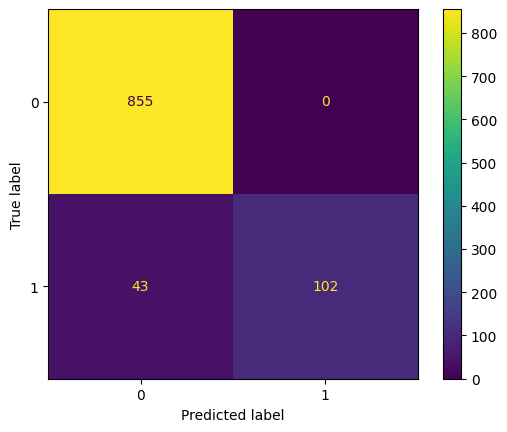

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [32]:
# Calcular log loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.1859


### Treinar modelo com CV e Tunning de Hiperparâmetros

In [33]:
# Criar um dict com os valores dos hiperparametros a serem testados
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth' : [None, 10,20,30],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,5,10]
}

In [35]:
# Configurar o GridSearchCV com 5 folds (com StratifiedKFold) e usando recall como metrica de validacao

rf_model_cv = RandomForestClassifier(class_weight='balanced', max_features='sqrt', random_state=51)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid, cv=kfolds, scoring='recall', verbose=2)

In [36]:
# Treinar modelo com cv 
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_de

,estimator,RandomForestC...ndom_state=51)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


Usando o conceito de CV, nós trabalhamos com conj de Treino + Val + Teste
x_train (50%) -> cross_validate -> 4 partições para treino + 1 val
Gera o melhor modelo e validamos com X_test(50%)

### Análise de Resultados - GridSearchCV

In [52]:
best_model = grid_search.best_estimator_

In [53]:
best_params = grid_search.best_params_

In [54]:
best_params

{'max_depth': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [55]:
best_score = grid_search.best_score_

In [56]:
best_score

np.float64(0.7805418719211822)

In [57]:
y_pred = best_model.predict(X_test)

In [58]:
# Retornar as probabilidades

y_pred_proba = best_model.predict_proba(X_test)

In [59]:
print("Relatorio de Classificação")
print(classification_report(y_test, y_pred))

Relatorio de Classificação
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       855
           1       1.00      0.81      0.90       145

    accuracy                           0.97      1000
   macro avg       0.98      0.91      0.94      1000
weighted avg       0.97      0.97      0.97      1000



In [60]:
fpr, tpr, threshoulds = roc_curve(y_test, y_pred_proba[:,1])

In [61]:
# Calcular AUC 

roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [62]:
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_yaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

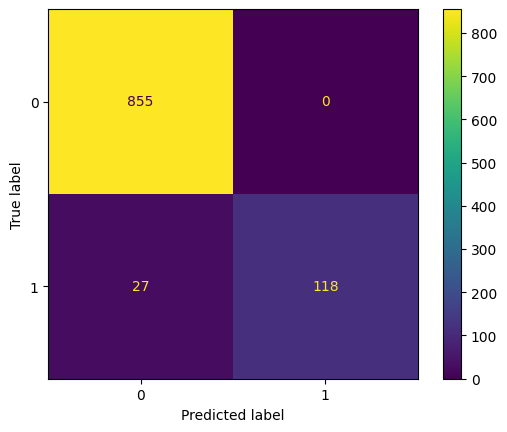

In [64]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [65]:
# Calcular log loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log Loss: 0.2503


### Ajustar Threshold

In [67]:
threshoulds = [0.3,0.4,0.5,0.6,0.7]

# Lista para armazar metricas

recalls = []

for threshould in threshoulds:
    # fazer predicoes com o threshold
    y_pred_threshold = (y_pred_proba[:,1] >= threshould).astype(int)
    
    recall = recall_score(y_test, y_pred_threshold)
    recalls.append(recall)

In [68]:
df_threshold = pd.DataFrame({'Threshold': threshoulds, 'Recall': recalls})

In [69]:
df_threshold.head(10)

,Threshold,Recall
0,0.3,0.917241
1,0.4,0.882759
2,0.5,0.813793
3,0.6,0.655172
4,0.7,0.400000


In [73]:
# Encontrar o threshold com o melhor recall

melhor_threshold = df_threshold.loc[df_threshold['Recall'].idxmax()]
print(f"Melhor Threshold: {melhor_threshold['Threshold']:.2f}")
print(f"Maior Recall: {melhor_threshold['Recall']:.4f}")

Melhor Threshold: 0.30
Maior Recall: 0.9172


In [75]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=threshoulds, y=recalls, name='Recall', line=dict(color='blue')))
fig.update_layout(
    title='Recall por Threshold',
    xaxis_title = 'Threshold',
    yaxis_title = 'Recall Score',
    width = 800,
    height = 500
)

fig.show()

### Análise de Metricas com o Threshold

In [77]:
y_pred = (y_pred_proba[:,1] >= melhor_threshold['Threshold']).astype(int)

In [78]:
print("Relatorio de Classificação")
print(classification_report(y_test, y_pred))

Relatorio de Classificação
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       855
           1       0.64      0.92      0.75       145

    accuracy                           0.91      1000
   macro avg       0.81      0.91      0.85      1000
weighted avg       0.93      0.91      0.92      1000



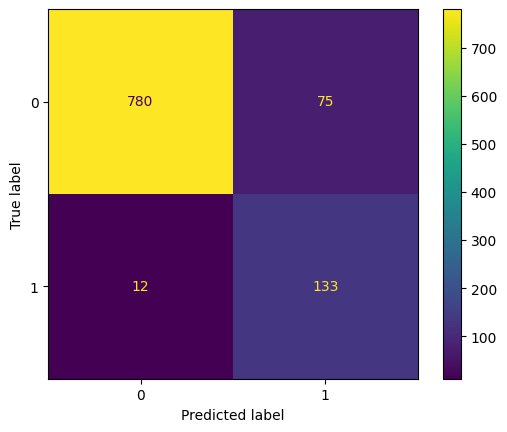

In [79]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

### Interpretabilidade

In [92]:
importance_features = best_model.feature_importances_
nomes_features = preprocessor.get_feature_names_out()

df_importances = pd.DataFrame({'Feature': nomes_features, 'Importancia': importance_features})
df_importances = df_importances.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

In [93]:
fig = px.bar(df_importances.head(10), x='Importancia', y='Feature', orientation='h', title="Importancia das Features (Top10)", color ='Importancia', color_continuous_scale='Viridis')
fig.update_layout(height=600, yaxis={'categoryorder': 'total ascending'})
fig.show()

In [95]:
# Visualizar tree do RF

def tree_visualization(modelo, index_tree, max_profundidade=5):
    plt.figure(figsize=(20,10))
    plot_tree(modelo.estimators_[index_tree],
              feature_names=nomes_features,
              class_names=['0','1'],
              filled=True,
              rounded=True,
              max_depth=max_profundidade,
              fontsize=9,
              proportion=True,
              precision=2)
    plt.title(f'Árvore {index_tree} da Random Forest')
    plt.tight_layout()
    plt.show()

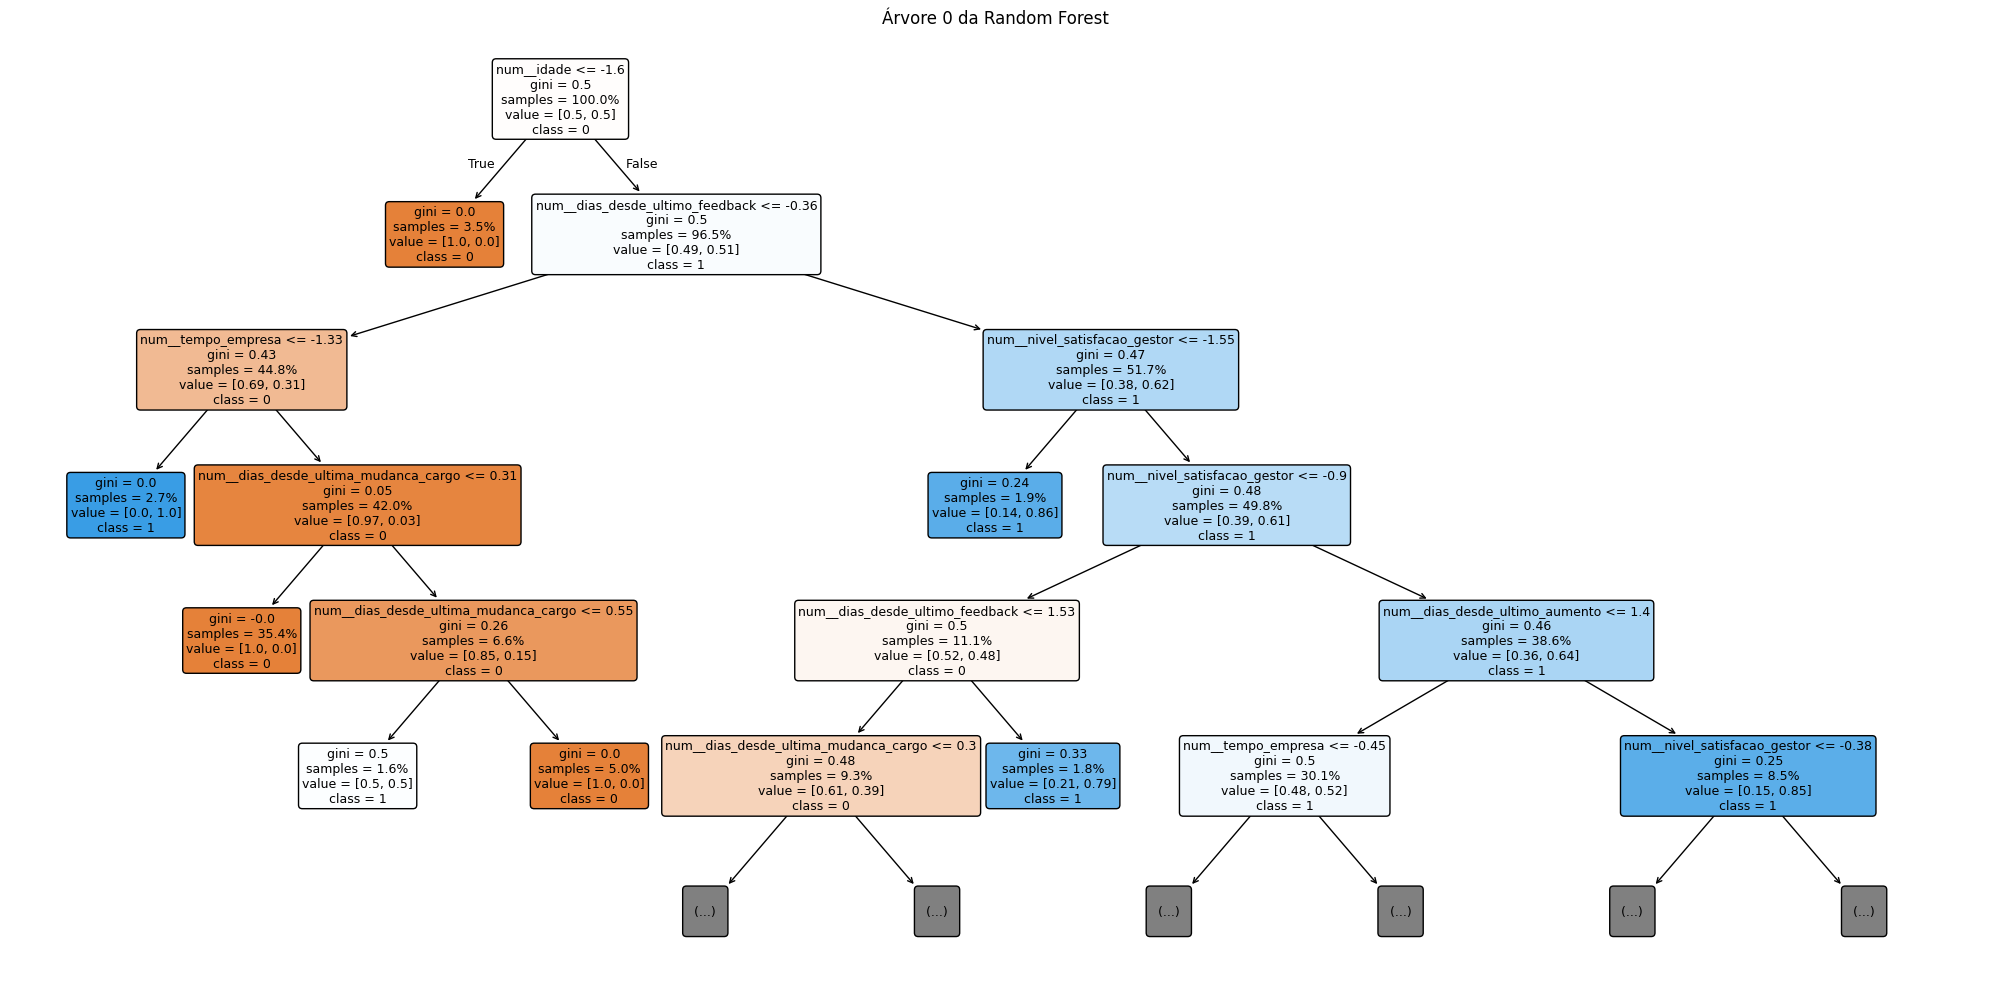

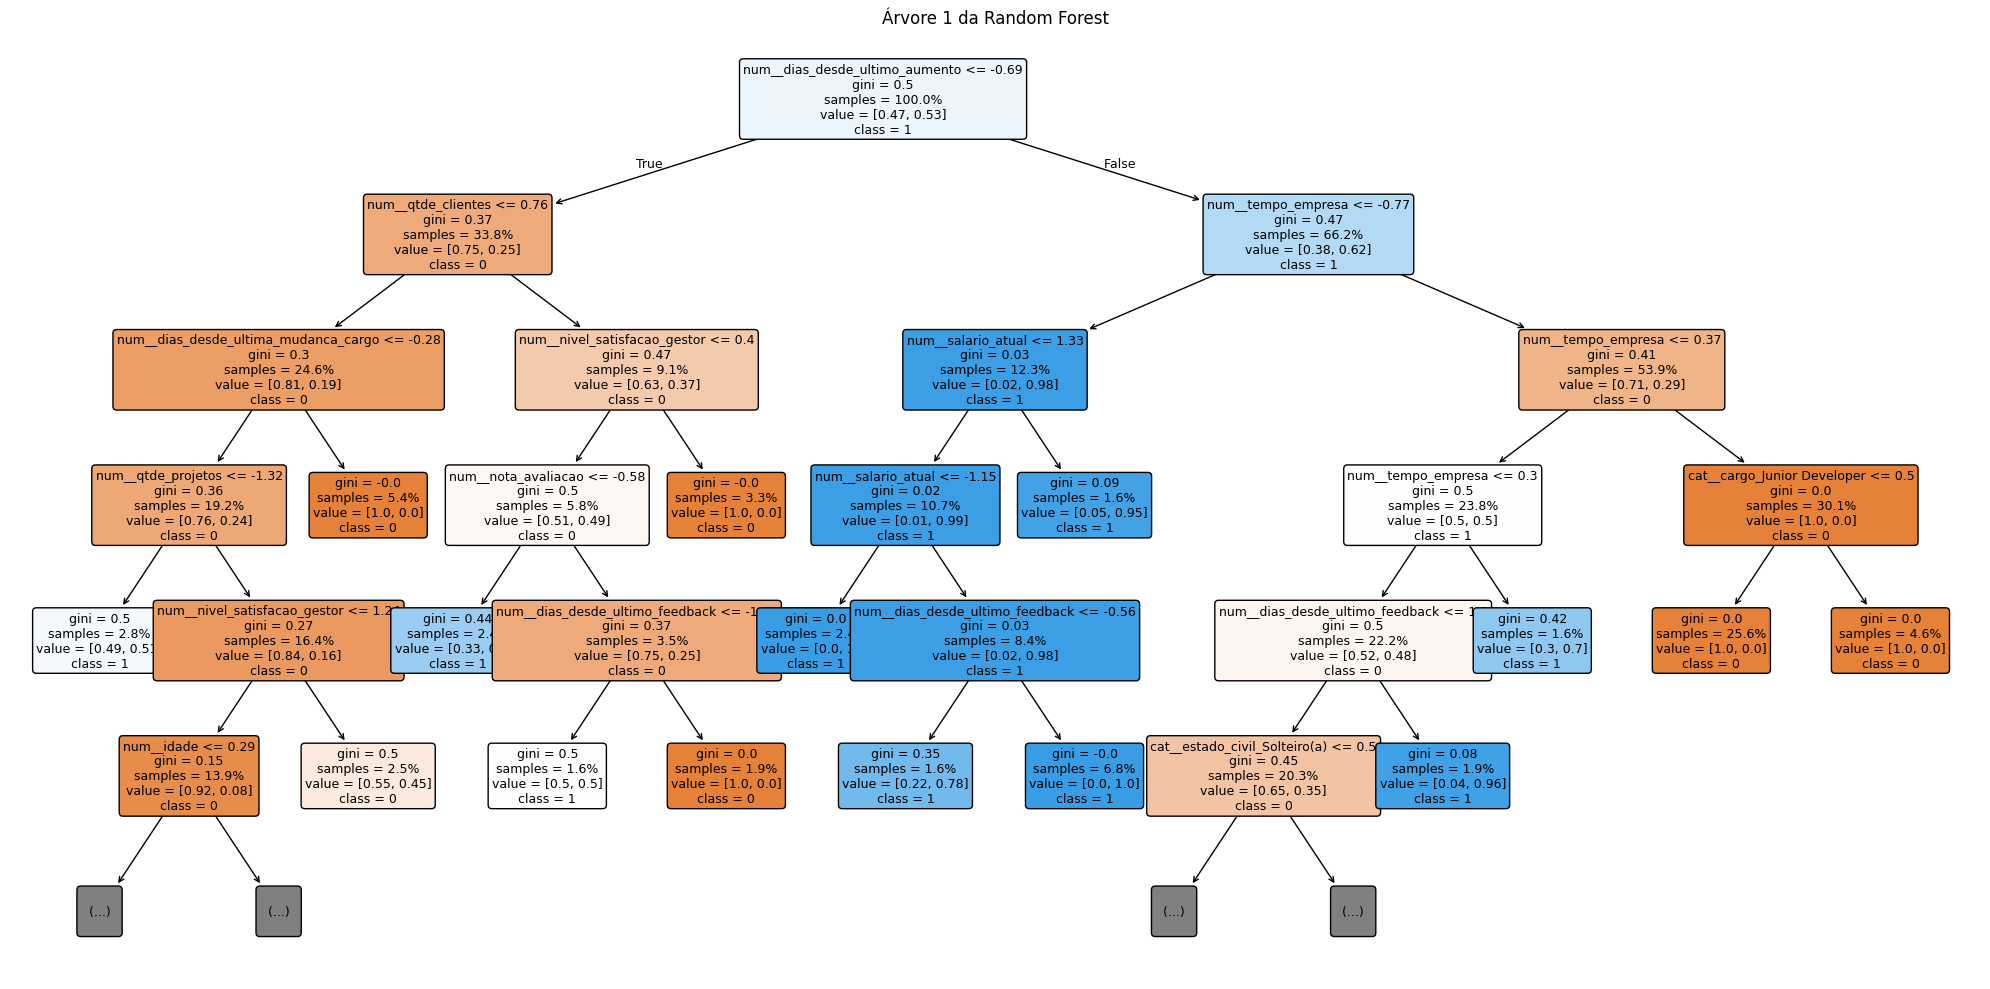

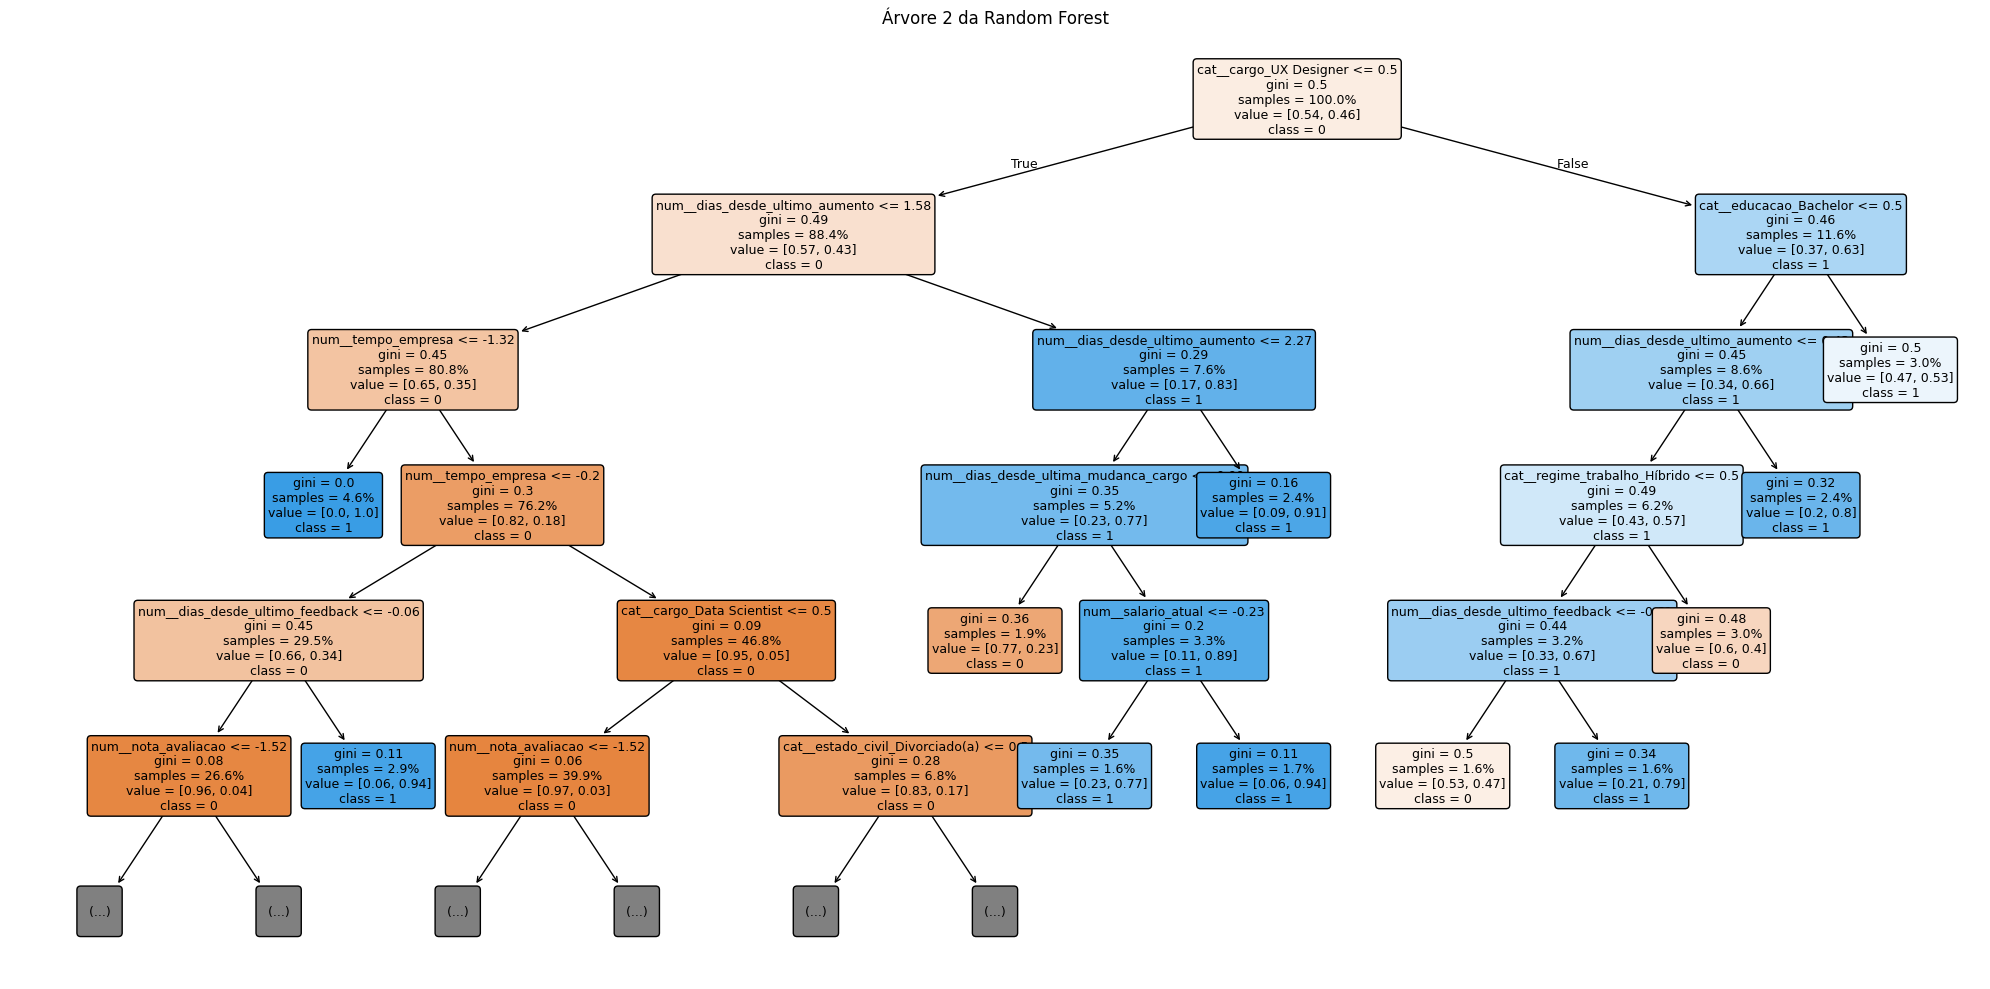

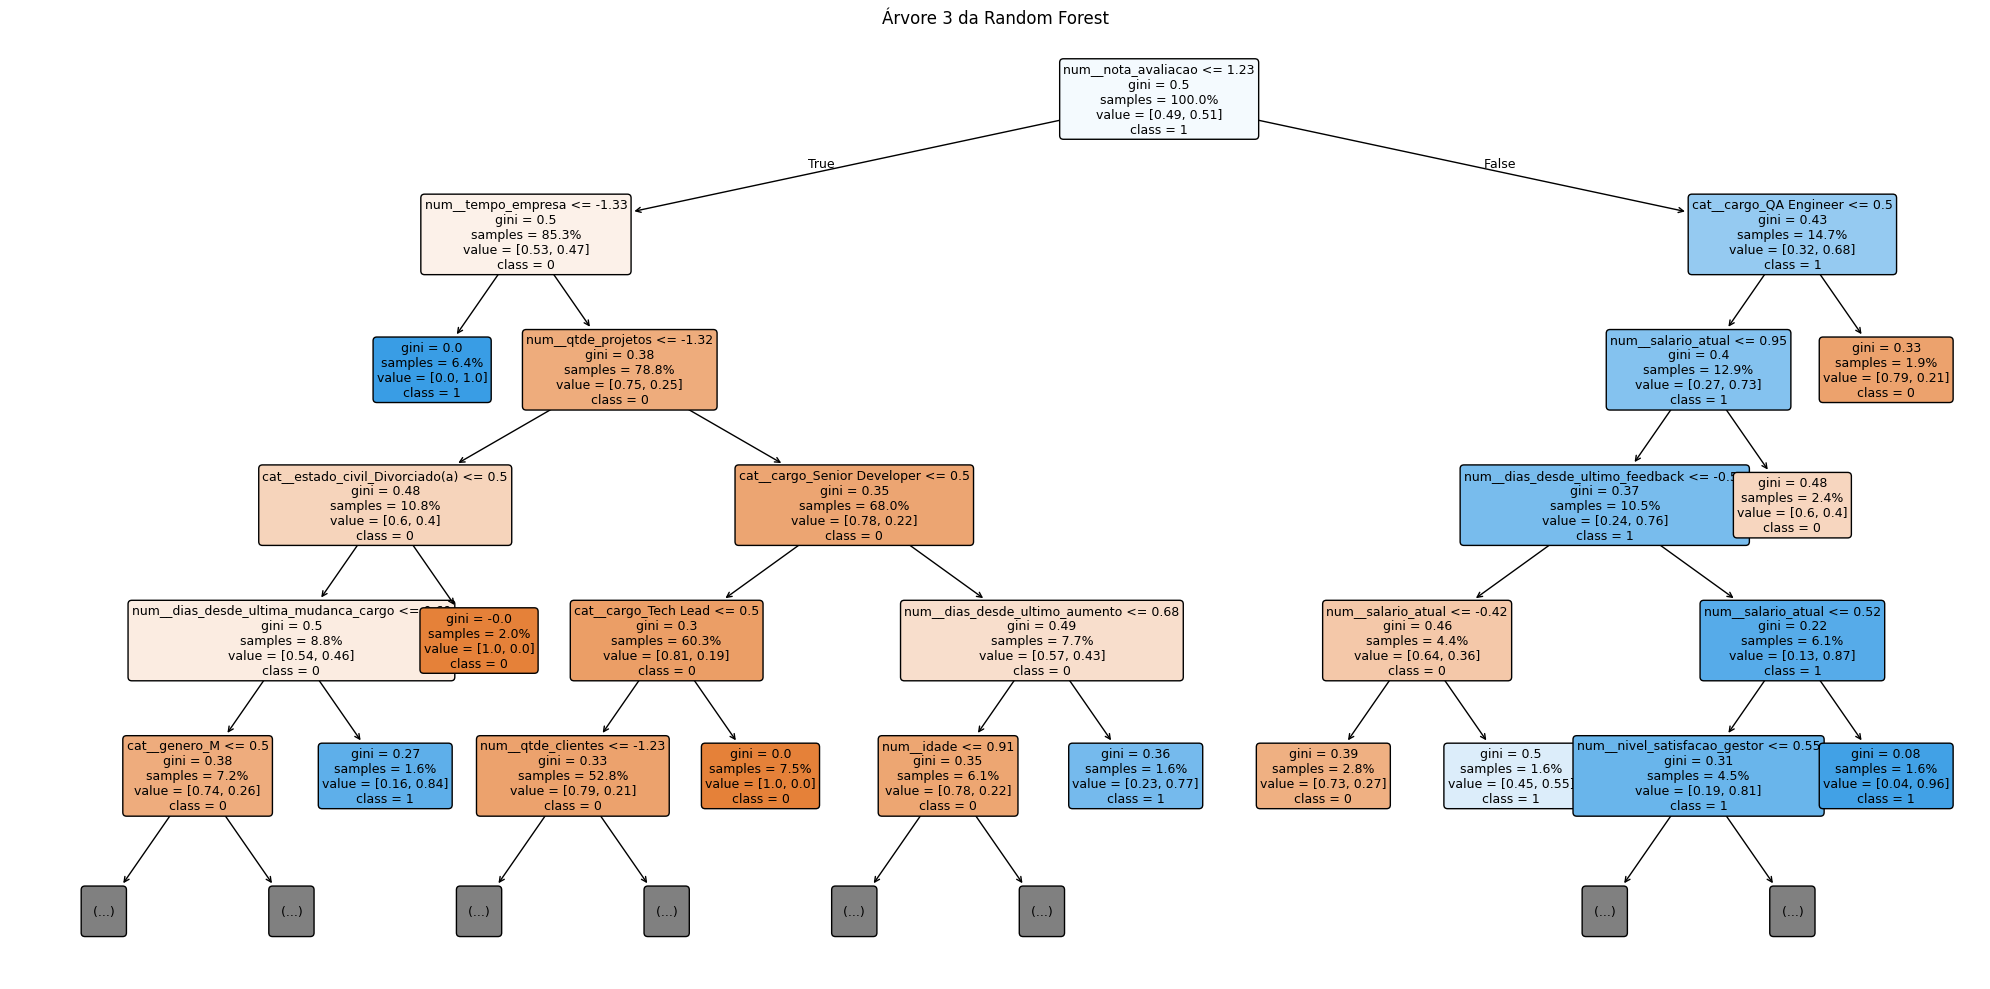

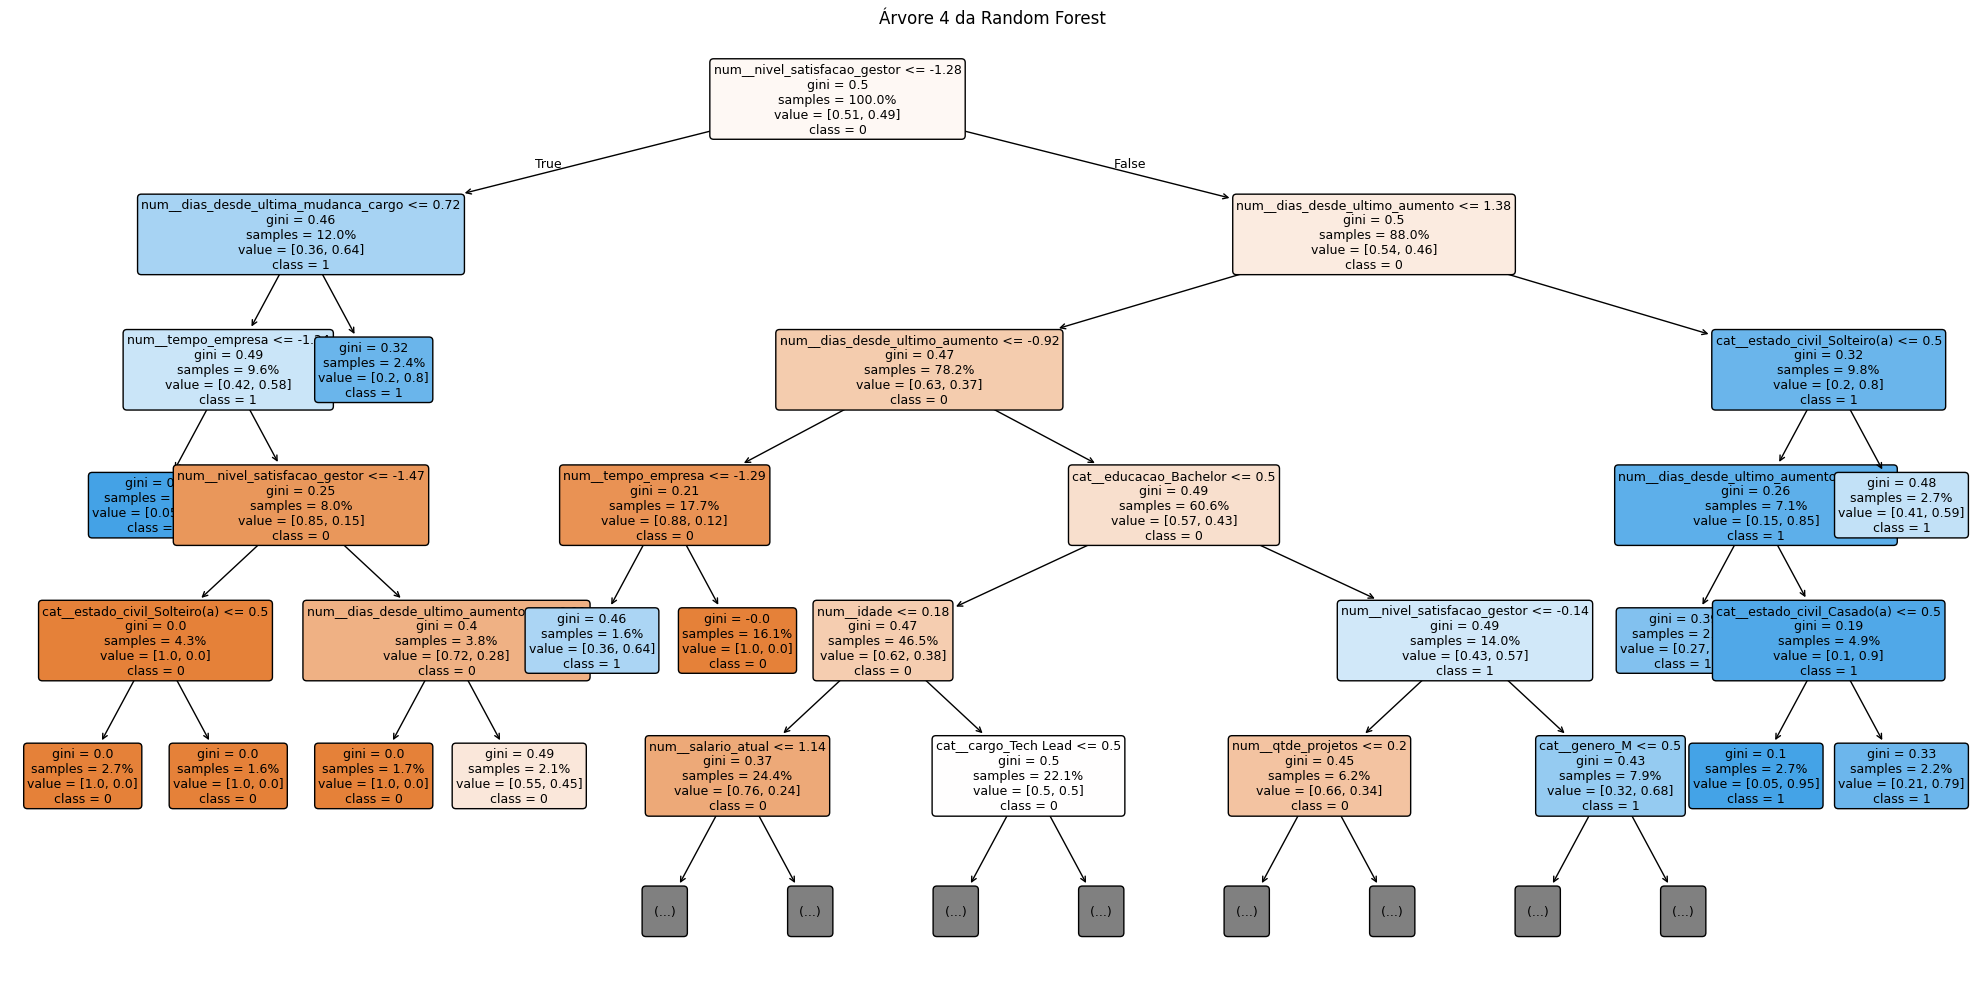

In [96]:
for i in range(0,5):
    tree_visualization(best_model, i)

### Apresentar Plots Shapley Values

In [98]:
explainer_class = shap.Explainer(best_model.predict, X_train, feature_names=nomes_features)

In [99]:
shap_values_class = explainer_class(X_test)

PermutationExplainer explainer: 1001it [09:12,  1.81it/s]                          


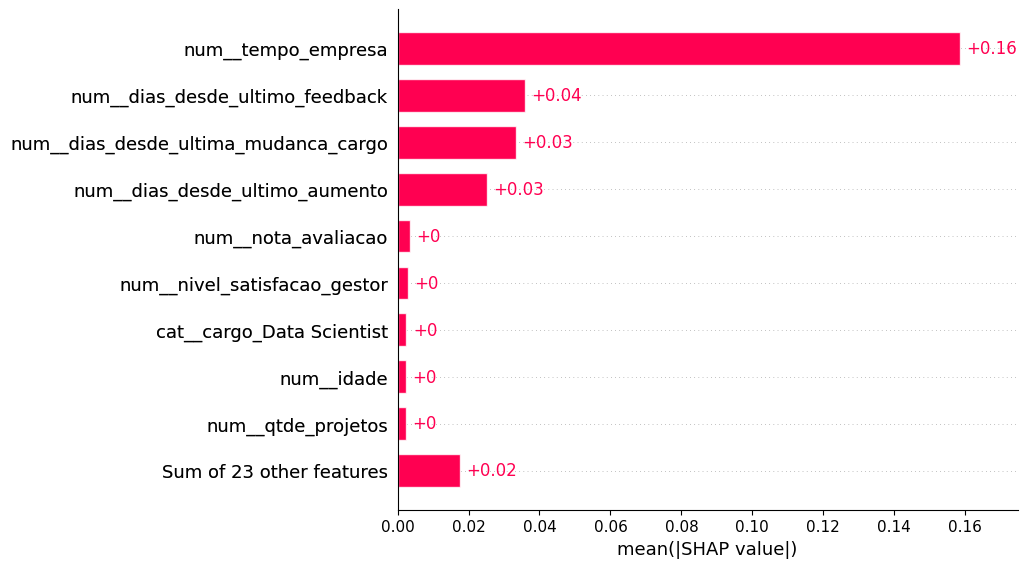

In [100]:
# Plotar a contribuição global por shapley values
shap.plots.bar(shap_values_class)

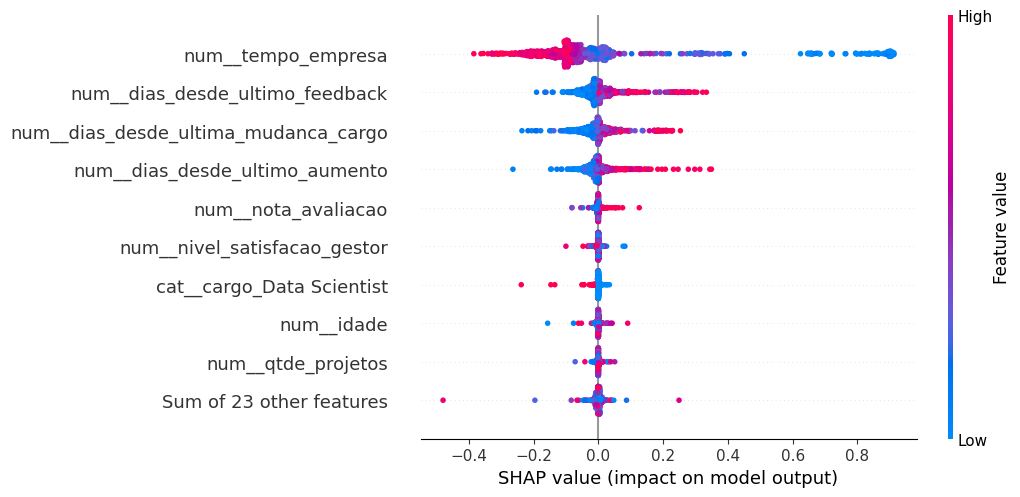

In [101]:
# Plot de Beeswarm Global
shap.plots.beeswarm(shap_values_class, max_display=10)

In [102]:
# Criar DF contendo y_test e y_pred
df_comparacao = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [103]:
df_comparacao

,y_test,y_pred
1617,0,0
885,0,0
433,0,0
188,0,1
1264,0,0
...,...,...
784,0,0
1914,0,0
227,1,0
316,1,1


In [104]:
# Valor real do 227
y_test[227]

np.int64(1)

In [105]:
# Valor predito do 227
y_pred[227]

np.int64(0)

In [106]:
# Dados do indice 227
X_test[227]

array([-0.50087032,  1.66458541, -0.10520997,  0.77154649,  0.01045753,
       -0.49864509,  0.14031924,  0.74134107, -0.92650459, -1.15716535,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [107]:
def inverse_transform_manual(X_transformed, preprocessor, feature_names):
    feature_names_original = feature_names
    df_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())
    df_original = pd.DataFrame(columns=feature_names_original)
    
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            # Para featurs numericas usar o inverse_transform
            df_original[features] = transformer.inverse_transform(
                df_transformed[[f'{name}__{f}' for f in features]]
            )
        elif name == 'cat': 
            # Para features categoricas precisamos identificar as colunas e qual delas tem o valor 1
            for feature in features:
                cols=[col for col in df_transformed.columns if col.startswith(f'{name}__{feature}')]
                for col in cols:
                    if df_transformed[col].iloc[0]==1:
                        df_original[feature] = col.split('__')[-1]
                        break
                    
    return df_original

In [110]:
# Trazer dados original do 227

inverse_transform_manual(X_test[[227]], preprocessor, X.columns)

,idade,genero,estado_civil,educacao,regime_trabalho,cargo,salario_atual,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
0,33.0,genero_Outro,estado_civil_Viúvo(a),educacao_PhD,regime_trabalho_Presencial,cargo_Product Manager,24347.0,7.9,NaN,7.0,4.0,4.1,1271.0,1167.0,518.0,422.0


In [111]:
# Probabailidade do index 227
y_pred_proba[227]

array([0.87680921, 0.12319079])

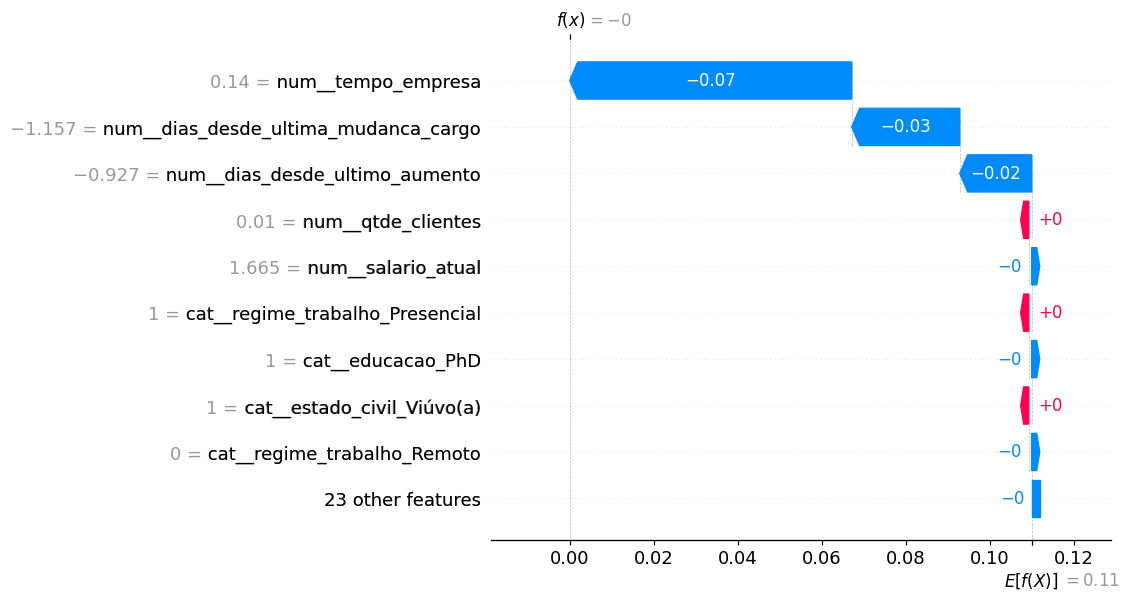

In [112]:
# Plortar Shapley Values para um ex especifico
shap.plots.waterfall(shap_values_class[227], max_display=10)